In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [4]:
from IPython.display import Image
from wordcloud import WordCloud, STOPWORDS
import string
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

## Učitavanje skupa podataka

In [5]:
data_train = pd.read_csv('data/train.csv')
data_test = pd.read_csv('data/test.csv')
test_labels = pd.read_csv('data/test_labels.csv')

Skup za obučavanje sadrži 159571 instanci, a skup za testiranje 153164 (ali će većina biti izbačeno jer ne postoje labele za njih). 

In [6]:
data_train.shape

(159571, 8)

In [7]:
data_test.shape, test_labels.shape

((153164, 2), (153164, 7))

In [8]:
data_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [9]:
test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


test i test_labels je potrebno spojiti preko id-ja

In [10]:
data_test = pd.merge(data_test, test_labels, on='id')

In [11]:
data_test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1


Instance koje za svih 6 klasa imaju vrednost -1 je potrebno izbaciti iz skupa (njih ima 89186)

In [12]:
#df = data_test[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
#p = df.iloc[:, :].sum(axis=1).value_counts()
#p

In [13]:
data_test = data_test[data_test['toxic'] != -1]

In [14]:
test_size = data_test.shape[0]

Sada je ostalo 63978 instanci u test skupu

In [15]:
train_size = data_train.shape[0]

train_size, test_size

(159571, 63978)

Dalje, trening i test skup biće spojeni radi zajedničke analize i pripreme, pa kasnije pred samo obučavanje modela ponovo izdvojeni

In [16]:
data = pd.concat([data_train, data_test])

In [17]:
data.shape

(223549, 8)

Dakle, celokupan skup podataka ima 223549 komentara koje je potrebno klasifikovati.

## Analiza skupa podataka

Komentari u tekstualnom formatu se nalaze u koloni comment_text, ostale kolone označavaju klase kojima komentar pripada, označene jedinicom za svaku klasu kojoj pripada, nulom u suprotnom. Kolonu id brišemo iz skupa.

In [18]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [19]:
data = data.drop(columns=['id'])
data.shape

(223549, 7)

Tipovi svake od kolona:

In [20]:
data.dtypes

comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object

Primer jedne instance, tj. komentara i njemu pridruženih klasa
- ovaj komentar označen je sa dve labele: toxic i insult

In [21]:
print(data['comment_text'][159546])
print('\n')
print(data.iloc[159546].drop(['comment_text']))

"

Hey listen don't you ever!!!! Delete my edits ever again I'm annoyed because the WWE 2K15 a few of the roster have been confirmed and your stupid ass deletes what I write. just stop!!!! Please STOP!!!! You don't work 2k or WWE games so stop deleting other peoples shit if I get it wrong or others get it wrong let them they will get the hang of it eventually but don't stick your most ass in their and I'm gonna delete the ""please do not insert the roster"" shit how do you not have it if has been confirmed!!!!! God your stupid."


toxic            1
severe_toxic     0
obscene          0
threat           0
insult           1
identity_hate    0
Name: 159546, dtype: object


Provera da li postoje neke nedostajuće vrednosti

In [22]:
data.isnull().any()

comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

Izdvajanje 6 klasa u promenljivu labels

In [23]:
labels = data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

In [24]:
labels.shape

(223549, 6)

### Vizualizacija podataka

Prikaz brojnosti komentara po klasama

In [25]:
frequency_per_class = labels.sum()
frequency_per_class

toxic            21384
severe_toxic      1962
obscene          12140
threat             689
insult           11304
identity_hate     2117
dtype: int64

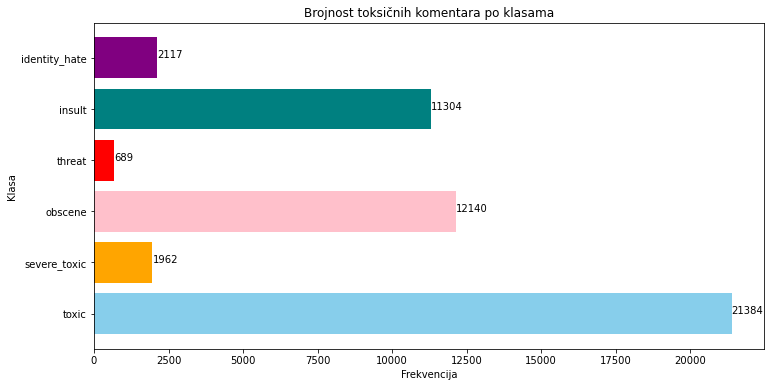

In [26]:
colors = ['skyblue', 'orange', 'pink', 'red', 'teal', 'purple', 'khaki']
plt.figure(figsize=(12, 6))
plt.title('Brojnost toksičnih komentara po klasama')
plt.xlabel('Frekvencija')
plt.ylabel('Klasa')

plt.barh(frequency_per_class.index, frequency_per_class.values, color=colors)
for index, value in enumerate(frequency_per_class):
    plt.text(value, index, str(value))
    
plt.savefig('plots and images/01_frequency_bar.png', orientation='landscape')
plt.show()

S obzirom na to da se radi o višelabelarnoj klasifikaciji, jedna instanca može pripadati istovremeno dvema ili više klasa. Komentar može npr. biti označen kao toksičan i uvreda, ali ne i pretnja, amože i spadati pod svih 6 obeležja i tako imati labelu koja za svih 6 klasa ima vrednost 1.

Zbog toga je dat i grafički prikaz broja komentara po tome da li su svrstani u jednu, dve, tri, četiri, pet, ili svih šest klasa.

In [27]:
counts = data.iloc[:, 1:].sum(axis=1).value_counts()
multilabels = counts[1:]
multilabels

1    8202
3    6290
2    5010
4    2371
5     550
6      45
dtype: int64

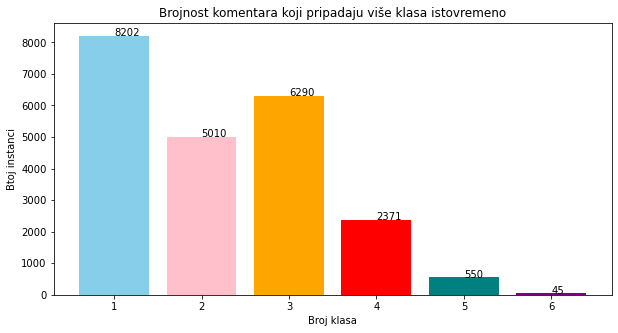

In [28]:
plt.figure(figsize=(10, 5))
plt.title('Brojnost komentara koji pripadaju više klasa istovremeno')
plt.xlabel('Broj klasa')
plt.ylabel('Btoj instanci')

plt.bar(multilabels.index, multilabels.values, color=colors)
for index, value in enumerate(multilabels.sort_index()):
    plt.text(index+1, value, str(value))

plt.savefig('plots and images/02_multilabels.png', orientation='landscape')

plt.show()

Dakle, najviše komentara pripada samo jednoj klasi, a samo 45 komentara ispunjava uslove za svaku od 6 klasa (istovremeno je toxic, severe_toxic, insult, obscene, threat i identity hate)

U vidu toplotne mape, predstavljene su korelacije između ovih labela

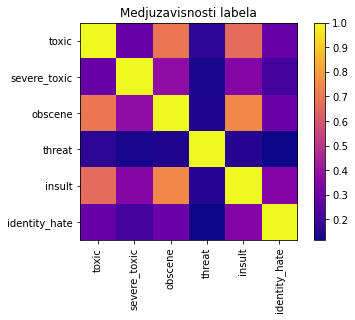

In [56]:
plt.imshow(labels.corr(), cmap='plasma')
plt.title('Medjuzavisnosti labela')
plt.xticks(range(0, 6), list(labels.columns), rotation='90')
plt.yticks(range(0, 6), list(labels.columns))
plt.colorbar()
plt.savefig('plots and images/heatmap_corr.png')
plt.show()

Može se zaključiti koje klase se najviše preklapaju, npr. uvrede su često i nepristojne (obscene).

U nastavku će biti prikazano koliko instanci nije klasifikovano u nijednu od ovih 6 klasa. Te instance zapravo predstavljaju "čiste", tj. netoksične komentare. Grafički prikaz biće dat u obliku pitice, kako bi se jasno video udeo toksičnih i netoksičnih komentara u celom skupu podataka.

In [27]:
untoxic = counts[0]
untoxic

201081

In [28]:
print('Udeo neoznacenih komentara:  {:.2%}'.format(untoxic/data.shape[0]))

Udeo neoznacenih komentara:  89.95%


Dakle, samo oko 10% celog skupa su toksični komentari.

Dodatno, ako posmatramo samo ovih 10% toksičnih komentara, i unutar njih važi neravnomerna raspodela po klasama (već je bilo prikazano gore u obliku stubića)

In [29]:
toxic = data.shape[0] - untoxic

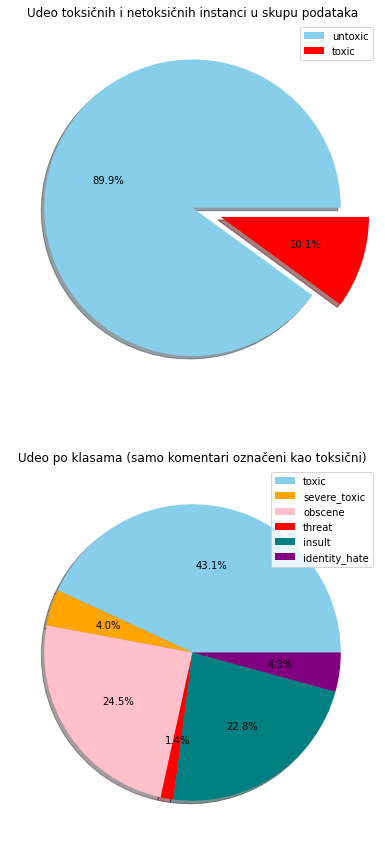

In [30]:
plt.figure(figsize=(10, 15))
plt.subplot(2, 1, 1)
plt.title('Udeo toksičnih i netoksičnih instanci u skupu podataka')
plt.pie([untoxic, toxic] , colors=['skyblue', 'red'], explode=[0, 0.2], autopct='%1.1f%%', shadow=True)
plt.legend(['untoxic', 'toxic'], loc='best')

plt.subplot(2, 1, 2)
plt.title('Udeo po klasama (samo komentari označeni kao toksični)')
plt.pie(frequency_per_class, colors=colors, autopct='%1.1f%%', shadow=True)
plt.legend(loc='best', labels=frequency_per_class.index)

plt.savefig('plots and images/03_pie_class_distribution.png')
plt.show()

Odavde je jasno da je skup podataka izuzetno neizbalansiran.

In [31]:
# prva podela

toxic, untoxic

(22468, 201081)

In [32]:
# druga podela

frequency_per_class

toxic            21384
severe_toxic      1962
obscene          12140
threat             689
insult           11304
identity_hate     2117
dtype: int64

Zbog ovoga, problem će biti podeljen na dva - biće odrađene dve klasifikacije: 
#### 1. Binarna klasifikacija na toksične (1) i netoksične (0)
#### 2. Višeklasna klasifikacija toksičnih komentara

Dodata je kolona target koja ima vrednost 0 ako je u pitanju netoksičan, a 1 ako je komentar toksičan.

In [33]:
data['target'] = np.where(data[labels.columns].sum(axis=1)==0, 0, 1)

In [34]:
data['target'].value_counts()

0    201081
1     22468
Name: target, dtype: int64

## Analiza teksta

Prvo će se odraditi čišćenje teksta - uklanjanje svih nepotrebnih karaktera 

In [35]:
def prepare_text(text):

    text = text.lower()  
    text = re.sub('<.*?>','',text).strip() 
    text = re.sub('\[|\(.*\]|\)','', text).strip() 
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    text = re.sub("(\\W)"," ",text).strip()
    text = re.sub('\S*\d\S*\s*','', text).strip()
    return text.strip()

Expand Contractions

Kontrakcije su skraćene verzije reči kao što su don't, how'll, ain't i slične. Njih je potrebno proširiti za bolju analizu sadržaja. 

Preuzeto sa  https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/

In [36]:
# Recnik kontrakcija na engleskom jeziku

contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not", "im" : "i am",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

Uklanjanje stop reči (prilozi, predlozi zamenice - reči koje su najfrekventnije, ali ne doprinose semantici)

In [37]:
# data.head()

def remove_stopwords(sentence):
    
    sw_list = stopwords.words('english')
    words = [word for word in sentence.split() if word not in sw_list]
    new_sentence = " ".join(words)
    
    return new_sentence

In [38]:
data['comment_text'] = data['comment_text'].apply(lambda x: prepare_text(x))

data['comment_text']=data['comment_text'].apply(lambda x:expand_contractions(x))

# data['comment_text'] = data['comment_text'].apply(lambda x : remove_stopwords(x))

Biće prikazane reči koje su najfrekventnije u instancama određenih klasa. U vidu oblaka reči, vizualizovane su reči koje se ponavljaju u toksičnim komentarima. Što je reč krupnija na slici, to se ona češće pojavljuje u skupu. Na osnovu ovoga, možemo da znamo kakve reči možemo očekivati u svakoj od klasa.

Funkcija koja formira wordcloud za konkretnu klasu:

In [39]:
def get_wordcloud(data, label, show=False):
    
    d = data[data[label]==1]
    words = ' '.join([text for text in d['comment_text'] ])

    wordcloud = WordCloud(width=2500,
                      height=1600,
                      max_words=500,
                      collocations=False,
                      stopwords=STOPWORDS).generate(words)

    if show:
        plt.title(str(label) + ' wordcloud')
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.savefig('plots and images/wordclouds/' + str(label) + '.png')
        plt.show()
        
    return wordcloud

In [40]:
#wordcloud_toxic = get_wordcloud(data, 'toxic', True)
#wordcloud_insult = get_wordcloud(data, 'insult', True)
#wordcloud_severe_toxic = get_wordcloud(data, 'severe_toxic', True)
#wordcloud_threat = get_wordcloud(data, 'threat', True)
#wordcloud_identity_hate = get_wordcloud(data, 'identity_hate', True)
#wordcloud_obscene = get_wordcloud(data, 'obscene', True)

Slike oblaka reči za svaku od labela sačuvane su u direktorijumu plots and images/wordclouds. Ovde je prikazana jedna od njih, konkretno za labelu 'threat'.

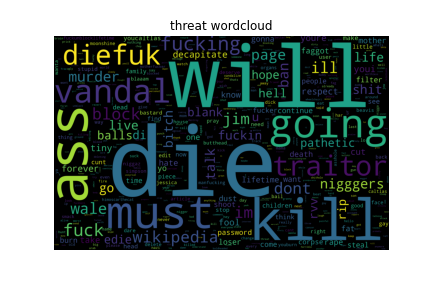

In [41]:
#Image('plots and images/wordclouds/toxic.png')
#Image('plots and images/wordclouds/severe_toxic.png')
#Image('plots and images/wordclouds/identity_hate.png')
#Image('plots and images/wordclouds/obscene.png')
#Image('plots and images/wordclouds/insult.png')
Image('plots and images/wordclouds/threat.png')

Mogu se predstaviti npr. pojavljivanja najčešćih n-grama reči

In [42]:
def plot_ngrams(instances,
                ngram_range=(1, 2),
                num_ngrams=25):
    
    vectorizer = CountVectorizer(ngram_range=(1, 3), dtype='int32', strip_accents='unicode',
                                 decode_error='replace', analyzer='word')

    vectorized = vectorizer.fit_transform(instances)

    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    all_counts = vectorized.sum(axis=0).tolist()[0]

    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.figure(figsize=(12, 5))
    plt.bar(idx, counts, width=0.8, color='skyblue')
    plt.xlabel('N-grami')
    plt.ylabel('Frekvencije')
    plt.title('Frekvencija ngrama')
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()

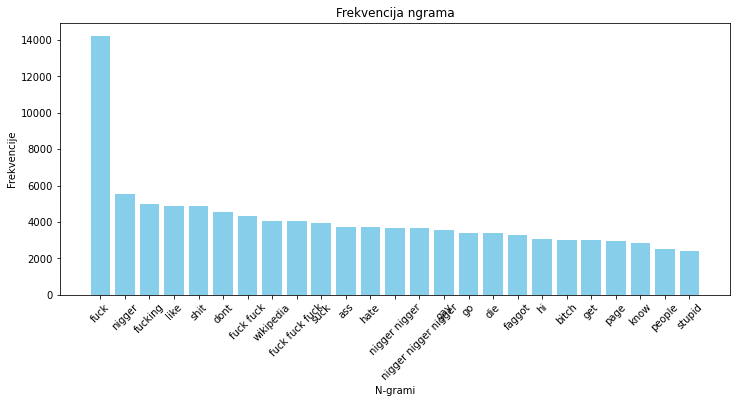

In [43]:
plot_ngrams(data[data['target']==1].comment_text.apply(lambda x : remove_stopwords(x)))

Ovo su najzastupljeniji unigrami, bigrami i trigrami u podacima koji imaju pridruženu neku od toksičnih klasa.

Dalje, možemo dodati atribut koji predstavlja broj reči po instanci, kako bismo imali uvid u to koliko su komentari dugački.

In [44]:
data['word_count'] = data['comment_text'].apply(lambda x : len(x.split()))
data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,target,word_count
0,explanation why the edits made under my userna...,0,0,0,0,0,0,0,43
1,daww he matches this background colour i am se...,0,0,0,0,0,0,0,15
2,hey man i am really not trying to edit war its...,0,0,0,0,0,0,0,43
3,more i cant make any real suggestions on i amp...,0,0,0,0,0,0,0,110
4,you sir are my hero any chance you remember wh...,0,0,0,0,0,0,0,13


Prikaz statistika za broj reči:

In [45]:
data['word_count'].describe()

count    223549.000000
mean         64.891031
std          98.227984
min           0.000000
25%          15.000000
50%          34.000000
75%          72.000000
max        2142.000000
Name: word_count, dtype: float64

In [46]:
# Broj komentara koji imaju samo jednu rec

data[data['word_count'] == 1].shape[0]

508

In [47]:
# Komentar koji ima najvecu duzinu 

data[data['word_count'] == int(data['word_count'].describe()['max'])]['comment_text']

99492    c o m m i e  f u c k e r c o m m i e  f u c k ...
Name: comment_text, dtype: object

Ovaj komentar je dugačak jer je napisan slovo po slovo sa razmacima

In [48]:
# Broj komentara koji imaju 0 reci

data[data['word_count'] == 0].shape[0]

96

In [49]:
data = data[data['word_count'] != 0]

In [50]:
data.shape

(223453, 9)

Histogram za broj reči po komentaru

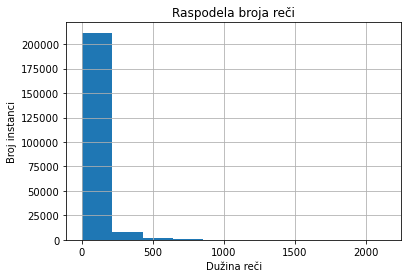

In [51]:
plt.title('Raspodela broja reči')
data['word_count'].hist()
plt.xlabel('Dužina reči')
plt.ylabel('Broj instanci')

plt.savefig('plots and images/04_hist_word_count.png')
plt.show()

Većina komentara ima do 200 reči. Podelićemo prethodni histogram na dva: prvi predstavlja raspodelu instanci koje imaju do 200 reči, a drugi raspodelu onih dužih komentara (više od 200 reči), koji su u manjini 

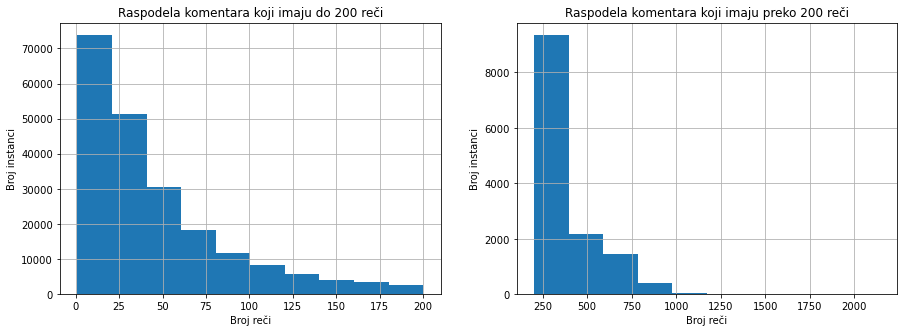

In [52]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Raspodela komentara koji imaju do 200 reči')
data[data['word_count'] <= 200]['word_count'].hist()
plt.xlabel('Broj reči')
plt.ylabel('Broj instanci')

plt.subplot(1, 2, 2)
plt.title('Raspodela komentara koji imaju preko 200 reči')
data[data['word_count'] > 200]['word_count'].hist()
plt.xlabel('Broj reči')
plt.ylabel('Broj instanci')

plt.savefig("plots and images/05_hist_wordcount_split.png")
plt.show()

Prosečan broj reči po instanci: 

In [53]:
average_word_count = data['word_count'].mean()
average_word_count

64.91890912182875

#### Prosečna dužina komentara je oko 65 reči (bez uklanjanja stop reči).

In [54]:
data.to_csv('data/data_longer.csv')